# MACC Figure and Analysis Generation
This script will create the necessary figures and analysis for marginal abatement cost curves 
### Table of Contents
* Establish constants/read libraries
* Fundamental Calculations
  * Read/Prepare data
  * Calculate closest solar/wind CFs
  * Calculate US MACC
* Analysis
  * Plot US MACC
  * Maps
    * All decisions
    * Gas combined cycle replacements
    * Gas single cycle replacements
  * State level curves
  * Upfront costs
  * Effectiveness of carbon taxes

## Establish constants/read libraries

In [1]:

import sys
import os
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.spatial import distance
import geopandas as gpd
import seaborn as sns
from scipy import stats 
from statsmodels.graphics.tsaplots import plot_acf 
import statistics
import plotnine as p9
from plotnine import *



# This should eventually be moved to an __init__.py file 
sys.path.insert(0, './functions/')
sys.path.insert(0, './data/')
import read_data as rd
import cost 
import replacement
import constants
import plotMACC

%matplotlib inline
%load_ext autoreload
%autoreload 2


## Fundamental Calculations
### Read/Prepare data

In [2]:
# Read data

# Process fuel prices for states that dont have prices (cost for 2022 fuel prices)
regional_fuel_price = rd.process_regional_fuel_price(os.getcwd()) 
plant_data, cost_data, cf_data, age_data, emisisons_data, pv_cf_data, wind_cf_data = rd.read_data(os.getcwd())
plant_data = rd.clean_plant_data(plant_data)
plant_data.to_csv(os.path.join(os.getcwd(), "output", "Plant_Processed", "2022_plant.csv"))
age_data.to_csv(os.path.join(os.getcwd(), "output", "Plant_Processed", "2022_age.csv"))
cost_data.to_csv(os.path.join(os.getcwd(), "output", "Plant_Processed", "2022_cost_data.csv"))



# Format costs, capacity factors, and emissions as dicts to be fed into functions 
cost_dict = cost_data.to_dict("dict")
cf_dict = dict(zip(cf_data.index, cf_data.capacity_factor.values))
emissions_dict = dict(zip(emisisons_data.index, emisisons_data.co2_lb_per_mmbtu.values*constants.lb_kg*constants.kg_tonne/constants.mmbtu_btu))


#Process State Plant Cost Data 
state_plant_cost = rd.process_regional_plant_cost(os.getcwd(),1,tax=0)
state_plant_cost_tax = rd.process_regional_plant_cost(os.getcwd(),1,tax=1)


# Read and Process all ABT DATA for Plant Cost Trends 

[natural_gas_cc_trend,natural_gas_cc_ccs_trend,natural_gas_sc_trend,land_wind_trend,pv_trend,coal_trend] = rd.ABT_process(os.getcwd())

# Output to CSV files 
natural_gas_cc_trend.to_csv(os.path.join(os.getcwd(), "data", "processing", "NREL", "natural_gas_cc_trend.csv"))
natural_gas_cc_ccs_trend.to_csv(os.path.join(os.getcwd(), "data", "processing", "NREL", "natural_gas_cc_ccs_trend.csv"))
natural_gas_sc_trend.to_csv(os.path.join(os.getcwd(), "data", "processing", "NREL", "natural_gas_sc_trend.csv"))
land_wind_trend.to_csv(os.path.join(os.getcwd(), "data", "processing", "NREL", "land_wind_trend.csv"))
pv_trend.to_csv(os.path.join(os.getcwd(), "data", "processing", "NREL", "pv_trend.csv"))
coal_trend.to_csv(os.path.join(os.getcwd(), "data", "processing", "NREL", "coal_trend.csv"))



/Users/natalieciaccia/Desktop/Research_Winter_22/MACCpy-main/./functions/read_data.py:157: DtypeWarning: Columns (5,13) have mixed types. Specify dtype option on import or set low_memory=False.


In [9]:
# Find Plants in Texas 

texas_plants =plant_data[plant_data.state == "TX"]
num_plants = len(texas_plants)
print(num_plants)

117


### Calculate closest solar/wind CFs

In [10]:
points = plant_data.loc[:, ["lat", "lon"]].values
pv_locs = pv_cf_data[["latitude", "longitude"]].values
wind_locs = wind_cf_data[["latitude", "longitude"]].values

pv_cfs = replacement.select_cf(points, pv_locs, pv_cf_data["capacity_factor"].values)
wind_cfs = replacement.select_cf(points, wind_locs, wind_cf_data["capacity_factor"].values)

hold_dict = cf_dict.copy()
hold_dict["Solar"] = pv_cfs
hold_dict["Wind"] = wind_cfs


### Find Plants That Are Close to Retirement 

In [4]:
# Find Plants and create new dataframe 

# Constants 
lifetime = 60 
curr_year = 2023

# Create Empty dataframes with same columns as original plant data 
old_plant_data = plant_data.iloc[:0]
young_plant_data = old_plant_data 
# Find plants and add to new dataframe 
for plant in plant_data["name"]:
    age = curr_year - plant_data.loc[plant_data['name'] == plant, 'commissioning_year'].iloc[0]
    if (lifetime-age) <=10:
        old_plant = plant_data.loc[plant_data["name"] == plant]
        old_plant_data = pd.concat([old_plant_data,old_plant])
    if(lifetime-age) >= 10: 
        young_plant = plant_data.loc[plant_data["name"] == plant]
        young_plant_data = pd.concat([young_plant_data,young_plant])

old_plant_data.to_csv(os.path.join(os.getcwd(), "output", "Plant_Processed", "2022_plant_old.csv"))
young_plant_data.to_csv(os.path.join(os.getcwd(), "output", "Plant_Processed", "2022_plant_young.csv"))


## Calculate US MACC Transitioning All Plants in 2022


### ITC Tax Credit

In [5]:
plant_data["rep_fuel"], plant_data["metric"], plant_data["em_red"] = replacement.replacement_df(plant_data, cost_dict, regional_fuel_price, state_plant_cost_tax, hold_dict, emissions_dict, 0, 0.06, 30,metric=1)
US_MACC_tax = replacement.set_macc(plant_data, neg_cap = -200, cap = 200)
US_MACC_tax["ori_rep"] = US_MACC_tax["ori_rep"].replace("CC_|SC_", "", regex = True) 
new_capacity = replacement.size_capacity(US_MACC_tax["capacity"],(US_MACC_tax["rep_fuel"].map(cf_dict)))*8760 # converting back to MW
US_MACC_tax["new_capacity"] = new_capacity 
US_MACC_tax.to_csv(os.path.join(os.getcwd(), "output", "MACC_DATA", "2022_MACC_ITC_tax.csv"))


### Non Tax 

In [11]:
plant_data["rep_fuel"], plant_data["metric"], plant_data["em_red"] = replacement.replacement_df(plant_data, cost_dict, regional_fuel_price, state_plant_cost, hold_dict, emissions_dict, 0, 0.06, 30,metric=1)
US_MACC_2022 = replacement.set_macc(plant_data, neg_cap = -200, cap = 200)
US_MACC_2022["ori_rep"] = US_MACC_2022["ori_rep"].replace("CC_|SC_", "", regex = True) 
new_capacity = replacement.size_capacity(US_MACC_2022["capacity"],(US_MACC_2022["rep_fuel"].map(cf_dict)))*8760 # converting back to MW
US_MACC_2022["new_capacity"] = new_capacity 
US_MACC_2022.to_csv(os.path.join(os.getcwd(), "output", "MACC_DATA", "2022_MACC.csv"))


In [16]:
texas_plants = US_MACC_2022[US_MACC_2022.state == "TX"] 
print(len(texas_plants))
sum_emissions = sum(US_MACC_2022["em_red"])
print(sum_emissions/10**6)

94
979945731.3692605


TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

### No Gas Case     

In [38]:
plant_data["rep_fuel"], plant_data["metric"], plant_data["em_red"] = replacement.replacement_df(plant_data, cost_dict, regional_fuel_price, state_plant_cost, hold_dict, emissions_dict, 0, 0.06, 30,metric=1,subset =["Solar", "Wind"])
US_MACC_2022_no_gas= replacement.set_macc(plant_data, neg_cap = -200, cap = 200)
US_MACC_2022_no_gas["ori_rep"] = US_MACC_2022_no_gas["ori_rep"].replace("CC_|SC_", "", regex = True) 
new_capacity = replacement.size_capacity(US_MACC_2022_no_gas["capacity"],(US_MACC_2022_no_gas["rep_fuel"].map(cf_dict)))*8760 # converting back to MW
US_MACC_2022_no_gas["new_capacity"] = new_capacity 
US_MACC_2022_no_gas.to_csv(os.path.join(os.getcwd(), "output", "MACC_DATA", "2022_MACC_no_gas.csv"))


### No Gas to Gas

In [ ]:
# Make gas-> gas not an option 

gas_org = plant_data.loc[(plant_data["primary_fuel"] == "Gas_SC") | (plant_data["primary_fuel"] == "Gas_CC")]
points = gas_org.loc[:, ["lat", "lon"]].values
pv_locs = pv_cf_data[["latitude", "longitude"]].values
wind_locs = wind_cf_data[["latitude", "longitude"]].values

pv_cfs = replacement.select_cf(points, pv_locs, pv_cf_data["capacity_factor"].values)
wind_cfs = replacement.select_cf(points, wind_locs, wind_cf_data["capacity_factor"].values)

hold_dict = cf_dict.copy()
hold_dict["Solar"] = pv_cfs
hold_dict["Wind"] = wind_cfs

#Process State Plant Cost Data 
state_plant_cost = rd.process_regional_plant_cost(os.getcwd(),1,tax=0)
state_plant_cost_tax = rd.process_regional_plant_cost(os.getcwd(),1,tax=1)

gas_org["rep_fuel"], gas_org["metric"], gas_org["em_red"] = replacement.replacement_df(gas_org, cost_dict, regional_fuel_price, state_plant_cost, hold_dict, emissions_dict, 0, 0.06, 30,metric=1,subset =["Solar", "Wind"])
US_MACC_2022_no_gas_gas= replacement.set_macc(gas_org, neg_cap = -200, cap = 200)
US_MACC_2022_no_gas_gas["ori_rep"] = US_MACC_2022_no_gas_gas["ori_rep"].replace("CC_|SC_", "", regex = True) 
new_capacity = replacement.size_capacity(US_MACC_2022_no_gas_gas["capacity"],(US_MACC_2022_no_gas_gas["rep_fuel"].map(cf_dict)))*8760 # converting back to MW
US_MACC_2022_no_gas_gas["new_capacity"] = new_capacity 
US_MACC_2022_no_gas_gas.to_csv(os.path.join(os.getcwd(), "output", "MACC_DATA", "2022_MACC_no_gas_gas.csv"))

coal_oil_org = plant_data.loc[(plant_data["primary_fuel"] == "Coal") | (plant_data["primary_fuel"] == "Oil")]


points = coal_oil_org.loc[:, ["lat", "lon"]].values
pv_locs = pv_cf_data[["latitude", "longitude"]].values
wind_locs = wind_cf_data[["latitude", "longitude"]].values
pv_cfs = replacement.select_cf(points, pv_locs, pv_cf_data["capacity_factor"].values)
wind_cfs = replacement.select_cf(points, wind_locs, wind_cf_data["capacity_factor"].values)
hold_dict = cf_dict.copy()
hold_dict["Solar"] = pv_cfs
hold_dict["Wind"] = wind_cfs


pv_cfs = replacement.select_cf(points, pv_locs, pv_cf_data["capacity_factor"].values)
wind_cfs = replacement.select_cf(points, wind_locs, wind_cf_data["capacity_factor"].values)

#Process State Plant Cost Data 
state_plant_cost = rd.process_regional_plant_cost(os.getcwd(),1,tax=0)
state_plant_cost_tax = rd.process_regional_plant_cost(os.getcwd(),1,tax=1)

# Format costs, capacity factors, and emissions as dicts to be fed into functions 
cost_dict = cost_data.to_dict("dict")
cf_dict = dict(zip(cf_data.index, cf_data.capacity_factor.values))
emissions_dict = dict(zip(emisisons_data.index, emisisons_data.co2_lb_per_mmbtu.values*constants.lb_kg*constants.kg_tonne/constants.mmbtu_btu))

coal_oil_org["rep_fuel"], coal_oil_org["metric"], coal_oil_org["em_red"] = replacement.replacement_df(coal_oil_org, cost_dict, regional_fuel_price, state_plant_cost, hold_dict, emissions_dict, 0, 0.06, 30,metric=1,subset =["Solar", "Wind","Gas"])
US_MACC_2022_coal_oil= replacement.set_macc(coal_oil_org, neg_cap = -200, cap = 200)
US_MACC_2022_coal_oil["ori_rep"] = US_MACC_2022_coal_oil["ori_rep"].replace("CC_|SC_", "", regex = True) 
new_capacity = replacement.size_capacity(US_MACC_2022_coal_oil["capacity"],(US_MACC_2022_coal_oil["rep_fuel"].map(cf_dict)))*8760 # converting back to MW
US_MACC_2022_coal_oil["new_capacity"] = new_capacity 
US_MACC_2022_coal_oil.to_csv(os.path.join(os.getcwd(), "output", "MACC_DATA", "2022_MACC_no_gas_gas.csv"))




US_MACC_2022_no_gas_to_gas = pd.concat([US_MACC_2022_no_gas_gas,US_MACC_2022_coal_oil])

# Sort the values by MACC
US_MACC_2022_no_gas_to_gas = US_MACC_2022_no_gas_to_gas.sort_values(by=['metric'])
# Recalculate cumulative emissions 
US_MACC_2022_no_gas_to_gas = US_MACC_2022_no_gas_to_gas.drop(columns=["cum_red","cum_red_prev","cum_emission"])
US_MACC_2022_no_gas_to_gas["cum_emission"]= np.cumsum(US_MACC_2022_no_gas_to_gas["emissions"])
US_MACC_2022_no_gas_to_gas["cum_red"] = np.cumsum(US_MACC_2022_no_gas_to_gas["em_red"])/constants.giga
US_MACC_2022_no_gas_to_gas["cum_red_prev"] = (np.cumsum(US_MACC_2022_no_gas_to_gas["em_red"])-US_MACC_2022_no_gas_to_gas["em_red"])/constants.giga

US_MACC_2022_no_gas_to_gas.to_csv(os.path.join(os.getcwd(), "output", "MACC_DATA", "2022_MACC_no_gas_gas.csv"))



### Calculate US MACC in 2023 for Plants with More Than 10 Years of Life Left

In [8]:
# Recalculate cf for new MACC calculations
points = young_plant_data.loc[:, ["lat", "lon"]].values
pv_locs = pv_cf_data[["latitude", "longitude"]].values
wind_locs = wind_cf_data[["latitude", "longitude"]].values
pv_cfs = replacement.select_cf(points, pv_locs, pv_cf_data["capacity_factor"].values)
wind_cfs = replacement.select_cf(points, wind_locs, wind_cf_data["capacity_factor"].values)
hold_dict = cf_dict.copy()
hold_dict["Solar"] = pv_cfs
hold_dict["Wind"] = wind_cfs


In [9]:
young_plant_data["rep_fuel"], young_plant_data["metric"], young_plant_data["em_red"] = replacement.replacement_df(young_plant_data, cost_dict,regional_fuel_price, state_plant_cost, hold_dict, emissions_dict, 0, 0.06, 30,metric=1)
US_MACC_2023_young = replacement.set_macc(young_plant_data, neg_cap = -200, cap = 200)
US_MACC_2023_young["ori_rep"] = US_MACC_2023_young["ori_rep"].replace("CC_|SC_", "", regex = True) 
US_MACC_2023_young.to_csv(os.path.join(os.getcwd(), "output", "MACC_DATA", "2023_young.csv"))


In [10]:
# Recalculate cf for new MACC calculations
points = old_plant_data.loc[:, ["lat", "lon"]].values
pv_locs = pv_cf_data[["latitude", "longitude"]].values
wind_locs = wind_cf_data[["latitude", "longitude"]].values
pv_cfs = replacement.select_cf(points, pv_locs, pv_cf_data["capacity_factor"].values)
wind_cfs = replacement.select_cf(points, wind_locs, wind_cf_data["capacity_factor"].values)
hold_dict = cf_dict.copy()
hold_dict["Solar"] = pv_cfs
hold_dict["Wind"] = wind_cfs

In [11]:
old_plant_data["rep_fuel"], old_plant_data["metric"], old_plant_data["em_red"] = replacement.replacement_df(old_plant_data, cost_dict,regional_fuel_price,state_plant_cost, hold_dict, emissions_dict, 0, 0.06, 30,metric=1)
US_MACC_2023_old = replacement.set_macc(old_plant_data, neg_cap = -200, cap = 200)
US_MACC_2023_old["ori_rep"] = US_MACC_2023_old["ori_rep"].replace("CC_|SC_", "", regex = True) 
US_MACC_2023_old.to_csv(os.path.join(os.getcwd(), "output", "MACC_DATA", "2023_old.csv"))


### Calculate US MACC in 2033, Waiting to Transition Plants Close to Retirement 




In [12]:
# Recalculate cf for new MACC calculations
points = old_plant_data.loc[:, ["lat", "lon"]].values
pv_locs = pv_cf_data[["latitude", "longitude"]].values
wind_locs = wind_cf_data[["latitude", "longitude"]].values
pv_cfs = replacement.select_cf(points, pv_locs, pv_cf_data["capacity_factor"].values)
wind_cfs = replacement.select_cf(points, wind_locs, wind_cf_data["capacity_factor"].values)
hold_dict = cf_dict.copy()
hold_dict["Solar"] = pv_cfs
hold_dict["Wind"] = wind_cfs


#### Update Costs Based on Trends 


In [73]:
# Constants 
curr_year = 2023
comission_year = 2033
dr = .06 

# Update Cost Dict With Costs From Trends Cost Type	Year	Unit	Cost
state_plant_cost = rd.process_regional_plant_cost(os.getcwd())

cost_dict["capital_cost_per_kw"]["Gas_CC"]  =  natural_gas_cc_trend.loc[(natural_gas_cc_trend["Cost Type"]=="CAPEX")&(natural_gas_cc_trend["Year"]==comission_year),"Cost"].values[0]
cost_dict["fixed_om_per_kw_year"]["Gas_CC"] =  natural_gas_cc_trend.loc[(natural_gas_cc_trend["Cost Type"]=="Fixed O&M")&(natural_gas_cc_trend["Year"]==comission_year),"Cost"].values[0]
cost_dict["variable_om_per_mwh"]["Gas_CC"]  = natural_gas_cc_trend.loc[(natural_gas_cc_trend["Cost Type"]=="Variable O&M")&(natural_gas_cc_trend["Year"]==comission_year),"Cost"].values[0]

cost_dict["capital_cost_per_kw"]["Gas_SC"]  =  natural_gas_sc_trend.loc[(natural_gas_sc_trend["Cost Type"]=="CAPEX")&(natural_gas_sc_trend["Year"]==comission_year),"Cost"].values[0]
cost_dict["fixed_om_per_kw_year"]["Gas_SC"] =  natural_gas_sc_trend.loc[(natural_gas_sc_trend["Cost Type"]=="Fixed O&M")&(natural_gas_sc_trend["Year"]==comission_year),"Cost"].values[0]
cost_dict["variable_om_per_mwh"]["Gas_SC"]  = natural_gas_sc_trend.loc[(natural_gas_sc_trend["Cost Type"]=="Variable O&M")&(natural_gas_sc_trend["Year"]==comission_year),"Cost"].values[0]

cost_dict["capital_cost_per_kw"]["Gas"]  =  natural_gas_sc_trend.loc[(natural_gas_sc_trend["Cost Type"]=="CAPEX")& (natural_gas_sc_trend["Year"]==comission_year),"Cost"].values[0]
cost_dict["fixed_om_per_kw_year"]["Gas"] =  natural_gas_sc_trend.loc[(natural_gas_sc_trend["Cost Type"]=="Fixed O&M")& (natural_gas_sc_trend["Year"]==comission_year),"Cost"].values[0]
cost_dict["variable_om_per_mwh"]["Gas"]  = natural_gas_sc_trend.loc[(natural_gas_sc_trend["Cost Type"]=="Variable O&M")& (natural_gas_sc_trend["Year"]==comission_year),"Cost"].values[0]



cost_dict["capital_cost_per_kw"]["Wind"]  =  land_wind_trend.loc[(land_wind_trend["Cost Type"]=="CAPEX")& (land_wind_trend["Year"]==comission_year),"Cost"].values[0]
cost_dict["fixed_om_per_kw_year"]["Wind"] = land_wind_trend.loc[(land_wind_trend["Cost Type"]=="Fixed O&M")& (land_wind_trend["Year"]==comission_year),"Cost"].values[0]

cost_dict["capital_cost_per_kw"]["Solar"]  =  pv_trend.loc[(pv_trend["Cost Type"]=="CAPEX")& (pv_trend["Year"]==comission_year),"Cost"].values[0]
cost_dict["fixed_om_per_kw_year"]["Solar"] = pv_trend.loc[(pv_trend["Cost Type"]=="Fixed O&M")& (pv_trend["Year"]==comission_year),"Cost"].values[0]



In [74]:
old_plant_data["rep_fuel"], old_plant_data["metric"], old_plant_data["em_red"] = replacement.replacement_df(old_plant_data,cost_dict,regional_fuel_price, hold_dict, emissions_dict, 0, 0.06, 30,metric=1)
US_MACC_2033 = replacement.set_macc(old_plant_data, neg_cap = -200, cap = 200)
US_MACC_2033["ori_rep"] = US_MACC_2033["ori_rep"].replace("CC_|SC_", "", regex = True) 
US_MACC_2033.to_csv(os.path.join(os.getcwd(), "output", "MACC_DATA", "2033_old.csv"))


/Users/natalieciaccia/Desktop/Research_Winter_22/MACCpy-main/./functions/replacement.py:328: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/natalieciaccia/Desktop/Research_Winter_22/MACCpy-main/./functions/replacement.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/natalieciaccia/Desktop/Research_Winter_22/MACCpy-main/./functions/replacement.py:330: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

### Using MACC Number As Deciding Factor for When to Transition- Taking Higher MACCs and waiting to transition them in 10 years 

In [118]:
# Find all wind transitions and only transition with specified perfecnt of reuslts that have lowest MACC 
Wind_Transition = US_MACC.loc[US_MACC["ori_rep"].isin(["Coal_Wind","Gas_Wind"])]
median_metric = Wind_Transition["metric"].median()


# Transition only plants that have a metric that is less than the median and reset cumulatvie emssions 
Wind_Transition_Now = Wind_Transition.loc[Wind_Transition["metric"]<= median_metric]
Wind_Transition_Now["cum_emission"]= np.cumsum(Wind_Transition_Now["emissions"])
Wind_Transition_Now["cum_red"] = np.cumsum(Wind_Transition_Now["em_red"])/constants.giga
Wind_Transition_Now["cum_red_prev"] = (np.cumsum(Wind_Transition_Now["em_red"])-Wind_Transition_Now["em_red"])/constants.giga
Wind_Transition_Now.to_csv(os.path.join(os.getcwd(), "output", "MACC_DATA", "wind.csv"))


# Take plants with higher MACC and do not transition them 
Wind_Transition_Later = Wind_Transition.loc[Wind_Transition["metric"]>= median_metric]
Wind_Transition_Later["cum_emission"]= np.cumsum(Wind_Transition_Later["emissions"])
Wind_Transition_Later["cum_red"] = np.cumsum(Wind_Transition_Later["em_red"])/constants.giga
Wind_Transition_Later["cum_red_prev"] = (np.cumsum(Wind_Transition_Later["em_red"])-Wind_Transition_Later["em_red"])/constants.giga
original_metric_wind = Wind_Transition_Later["metric"]

# Take plants that would transition to gas and transition them later to see if they would be replaced with wind 
NG_Transition_Later = US_MACC.loc[US_MACC["ori_rep"].isin(["Coal_Gas","Gas_Gas","Oil_Gas"])] 
NG_Transition_Later["cum_emission"]= np.cumsum(NG_Transition_Later["emissions"])
NG_Transition_Later["cum_red"] = np.cumsum(NG_Transition_Later["em_red"])/constants.giga
NG_Transition_Later["cum_red_prev"] = (np.cumsum(NG_Transition_Later["em_red"])-NG_Transition_Later["em_red"])/constants.giga
original_metric_ng = NG_Transition_Later["metric"]

Solar_Transition_Later = US_MACC.loc[US_MACC["ori_rep"].isin(["Coal_Solar","Gas_Solar"])] 
Solar_Transition_Later["cum_emission"]= np.cumsum(Solar_Transition_Later["emissions"])
Solar_Transition_Later["cum_red"] = np.cumsum(Solar_Transition_Later["em_red"])/constants.giga
Solar_Transition_Later["cum_red_prev"] = (np.cumsum(Solar_Transition_Later["em_red"])-Solar_Transition_Later["em_red"])/constants.giga
original_metric_solar = Solar_Transition_Later["metric"]


#Merge Plants Did not Transition with Non-Wind Transition Plants 
transition_2033 = pd.concat([Wind_Transition_Later, NG_Transition_Later,Solar_Transition_Later]) 
# Make separate df for transitioning now instead of 2033 
transition_present = transition_2033
# Sort the values by MACC
transition_present = transition_present.sort_values(by=['metric'])
# Recalculate cumulative emissions 
transition_present = transition_present.drop(columns=["cum_red","cum_red_prev","cum_emission"])
transition_present["cum_emission"]= np.cumsum(transition_present["emissions"])
transition_present["cum_red"] = np.cumsum(transition_present["em_red"])/constants.giga
transition_present["cum_red_prev"] = (np.cumsum(transition_present["em_red"])-transition_present["em_red"])/constants.giga


# Get rid of MACC calculations 
transition_2033 = transition_2033.drop(columns=["rep_fuel","metric","em_red","ori_rep","cum_red","cum_red_prev","cum_emission"])
# Make new df for plants that were suppsed to be gas transitions to see how their macc and replacement fuel changes if wait 10 years 

transition_2033__gas_only = NG_Transition_Later.drop(columns=["rep_fuel","metric","em_red","ori_rep","cum_red","cum_red_prev","cum_emission"])
## Calculate new MAC for transition in 2033 

# Constants 
curr_year = 2021
comission_year = 2033
dr = .06 

# Get economic trend 
cost_2033 = cost.cost_trend(O_M_cost_trend,Capital_cost_trend,comission_year)


# Calculate O&M and Capital Cost in 2021 dollars 
O_M_cost_2033_2021 = cost_2033[0]
Capital_cost_2033_2021 = cost_2033[1]


# Convert to 2033 dollars and replace in cost dictonary 
value_comission_year = (1+dr)**(comission_year-curr_year)
OM_cost_2033      = O_M_cost_2033_2021/value_comission_year 
Capital_cost_2033 = Capital_cost_2033_2021/value_comission_year

cost_dict["capital_cost_per_kw"]["Wind"] = Capital_cost_2033
cost_dict["fixed_om_per_kw_year"]["Wind"] = OM_cost_2033 

# Recalculate cf 
points = transition_2033.loc[:, ["lat", "lon"]].values
pv_locs = pv_cf_data[["latitude", "longitude"]].values
wind_locs = wind_cf_data[["latitude", "longitude"]].values
pv_cfs = replacement.select_cf(points, pv_locs, pv_cf_data["capacity_factor"].values)
wind_cfs = replacement.select_cf(points, wind_locs, wind_cf_data["capacity_factor"].values)
hold_dict = cf_dict.copy()
hold_dict["Solar"] = pv_cfs
hold_dict["Wind"] = wind_cfs


NameError: name 'US_MACC' is not defined

#### Calculate New MACCs 

In [6]:
# Calculating new MACC numbers for transition in 2033 
transition_2033["rep_fuel"], transition_2033["metric"], transition_2033["em_red"] = replacement.replacement_df(transition_2033, cost_dict, hold_dict, emissions_dict, 0, 0.06, 30,comission_year,metric=1)
US_MACC_2033 = replacement.set_macc(transition_2033, neg_cap = -200, cap = 200)
US_MACC_2033["ori_rep"] = US_MACC_2033["ori_rep"].replace("CC_|SC_", "", regex = True) 

# Recalculate cf for new MACC calculations
points = transition_2033__gas_only.loc[:, ["lat", "lon"]].values
pv_locs = pv_cf_data[["latitude", "longitude"]].values
wind_locs = wind_cf_data[["latitude", "longitude"]].values
pv_cfs = replacement.select_cf(points, pv_locs, pv_cf_data["capacity_factor"].values)
wind_cfs = replacement.select_cf(points, wind_locs, wind_cf_data["capacity_factor"].values)
hold_dict = cf_dict.copy()
hold_dict["Solar"] = pv_cfs
hold_dict["Wind"] = wind_cfs

# Calculate MACC for transitions that were originally coal->gas and gas-> gas and oil->gas only 
transition_2033__gas_only["rep_fuel"], transition_2033__gas_only["metric"], transition_2033__gas_only["em_red"] = replacement.replacement_df(transition_2033__gas_only, cost_dict, hold_dict, emissions_dict, 0, 0.06, 30,comission_year,metric=1)
US_MACC_2033_gas_repl_org = replacement.set_macc(transition_2033__gas_only, neg_cap = -200, cap = 200)
US_MACC_2033_gas_repl_org ["ori_rep"] = US_MACC_2033_gas_repl_org ["ori_rep"].replace("CC_|SC_", "", regex = True) 

c:\Users\natal\Desktop\Research Winter 22\MACCpy-main\./functions\replacement.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\natal\Desktop\Research Winter 22\MACCpy-main\./functions\replacement.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\natal\Desktop\Research Winter 22\MACCpy-main\./functions\replacement.py:312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

## Analysis
  * Plot US MACC
  * Maps
    * All decisions
    * Gas combined cycle replacements
    * Gas single cycle replacements
  * State level curves
  * Upfront costs

### Plot US MACC National

/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/natalieciaccia/Desktop/Research_Winter_22/MACCpy-main/output/NationalCurves/2022_MACC_ITC_tax_national.png
/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_rect : Removed 38 rows containing missing values.
/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_rect : Removed 38 rows containing missing values.


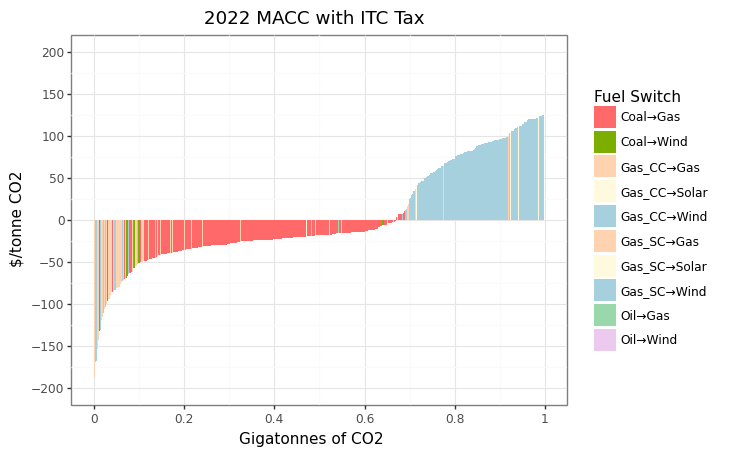

<ggplot: (8780399048271)>

In [28]:
plotMACC.plot_MACC(US_MACC_tax, title = " 2022 MACC with ITC Tax", x_lab = "Gigatonnes of CO2", save = True, file=os.path.join(os.getcwd(), "output", "NationalCurves", "2022_MACC_ITC_tax_national.png"))


/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/natalieciaccia/Desktop/Research_Winter_22/MACCpy-main/output/NationalCurves/2022_MACC_national.png


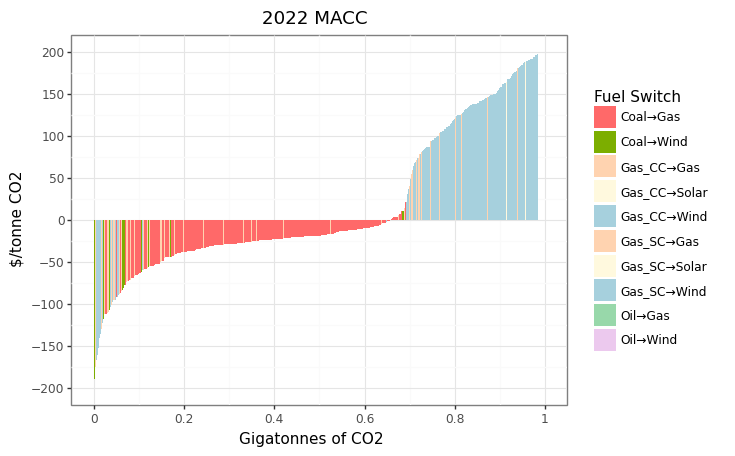

<ggplot: (8771785352418)>

In [7]:
plotMACC.plot_MACC(US_MACC_2022, title = " 2022 MACC", x_lab = "Gigatonnes of CO2", save = True, file=os.path.join(os.getcwd(), "output", "NationalCurves", "2022_MACC_national.png"))

/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/natalieciaccia/Desktop/Research_Winter_22/MACCpy-main/output/NationalCurves/2022_MACC_national_no_gas.png
/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_rect : Removed 246 rows containing missing values.
/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_rect : Removed 246 rows containing missing values.


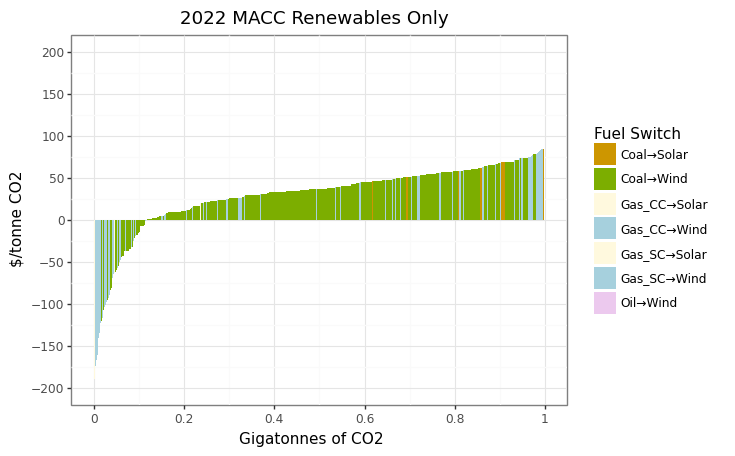

<ggplot: (8777026777323)>

In [71]:
plotMACC.plot_MACC(US_MACC_2022_no_gas, title = " 2022 MACC Renewables Only", x_lab = "Gigatonnes of CO2", save = True, file=os.path.join(os.getcwd(), "output", "NationalCurves", "2022_MACC_national_no_gas.png"))

/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/natalieciaccia/Desktop/Research_Winter_22/MACCpy-main/output/NationalCurves/2022_MACC_no_gas_to_gas_national.png
/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_rect : Removed 87 rows containing missing values.
/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_rect : Removed 87 rows containing missing values.


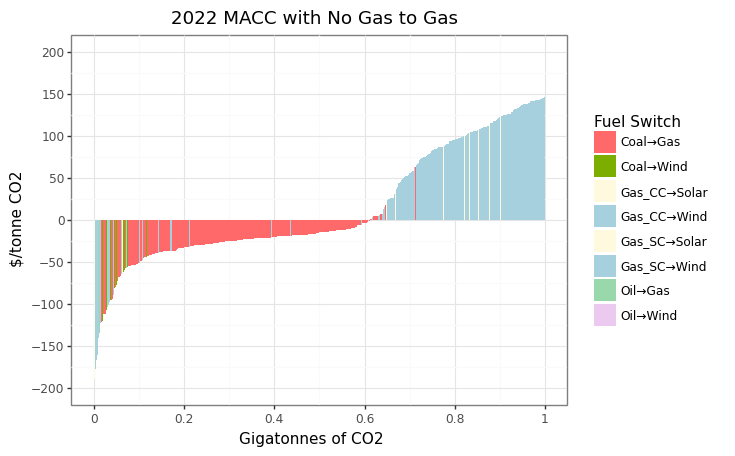

<ggplot: (8762397748215)>

In [11]:
plotMACC.plot_MACC(US_MACC_2022_no_gas_to_gas, title = " 2022 MACC with No Gas to Gas", x_lab = "Gigatonnes of CO2", save = True, file=os.path.join(os.getcwd(), "output", "NationalCurves", "2022_MACC_no_gas_to_gas_national.png"))


### Plot MACC by State 

/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning:

Filename: /Users/natalieciaccia/Desktop/Research_Winter_22/MACCpy-main/output/NationalCurves/2022_MACC_state.png



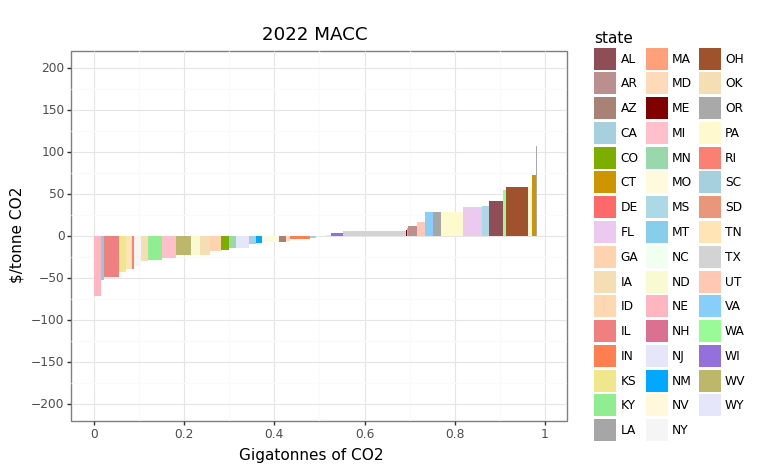

<ggplot: (8769510532139)>

In [43]:
plotMACC.plot_avg_MACC_per_state(US_MACC_2022, title = " 2022 MACC", x_lab = "Gigatonnes of CO2", save = True, file=os.path.join(os.getcwd(), "output", "NationalCurves", "2022_MACC_state.png"))

In [ ]:
#Find min and max average MACC and emissions reduction 

plant_avg_MACC =pd.read_csv(os.path.join(os.getcwd(), "output", "MACC_DATA","2022_state.csv"), header = 0, comment= "#")
print(plant_avg_MACC.columns)
max_em_redu = plant_avg_MACC['em_red'].idxmax()
state_max_red = plant_avg_MACC.loc[max_em_redu, 'state']
print(state_max_red)
plant_avg_MACC.sort_values(by=['em_red'])
print(plant_avg_MACC)
min_em_redu = plant_avg_MACC['metric'].idxmin()
state_min_red = plant_avg_MACC.loc[min_em_redu, 'state']



### State Level 


In [43]:
df1 = pd.DataFrame(columns = ["state","neg_MACC","high_MACC","num_solar","num_wind"])

#Plot and save data 
 
for state in set(plant_data["state"]):
    plotMACC.plot_state_MACC(US_MACC_2022,state,x_lab = "Gigatonnes of CO2", save = True, file=os.path.join(os.getcwd(), "output", "StateCurves", "2022_MACC_"+state+".png"))
     # Sort by state
    state_data = US_MACC_2022[US_MACC_2022.state == state]
    # Find high and low MACCs 
    num_high = (state_data.loc[state_data.metric > 50]).shape[0]
    num_neg = (state_data.loc[state_data.metric < 0]).shape[0]
    num_wind = (state_data.loc[state_data.rep_fuel == "Wind"]).shape[0]
    num_solar = (state_data.loc[state_data.rep_fuel == "Solar"]).shape[0]
    df1 = df1.append({'state': state, 'neg_MACC': num_neg,"high_MACC": num_high,"num_solar":num_solar,"num_wind":num_wind}, ignore_index=True)

df1.to_csv(os.path.join(os.getcwd(), "output", "MACC_DATA","State","MACC_state_count.csv"))




/Users/natalieciaccia/Desktop/Research_Winter_22/MACCpy-main/./functions/plotMACC.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/natalieciaccia/Desktop/Research_Winter_22/MACCpy-main/./functions/plotMACC.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filenam

### Discount Rate Sensitivity 

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# set up parameters
min_rate = 0.06
max_rate = 0.30
d_dr = .05 
dr_range = np.arange(min_rate,max_rate,d_dr)

#Make empty arrays 
size = [len(plant_data["state"]),int((max_rate-min_rate)/d_dr)+1]
metric = np.zeros(size)
cum_red = np.zeros(size)
counter =0 
x = min_rate 


# Sensitivity Analysis 
while x < max_rate: 
    plant_data["rep_fuel"], plant_data["metric"], plant_data["em_red"] = replacement.replacement_df(plant_data, cost_dict, regional_fuel_price, state_plant_cost, hold_dict, emissions_dict, 0, x, 30,metric=1)
    US_MACC = replacement.set_macc(plant_data, neg_cap=-200, cap=200)
    US_MACC["ori_rep"] = US_MACC["ori_rep"].replace("CC_|SC_", "", regex=True)
    new_capacity = replacement.size_capacity(US_MACC["capacity"], (US_MACC["rep_fuel"].map(cf_dict))) * 8760 # converting back to MW
    US_MACC["new_capacity"] = new_capacity 
    metric[0:len(US_MACC["metric"]),counter] = US_MACC["metric"]
    cum_red[0:len(US_MACC["metric"]),counter] = US_MACC["cum_red"]
    counter +=1
    x += d_dr  

# Plot 
for i in range(counter):
    cum_red_col = cum_red[:, i]
    metric_col = metric[:, i]
    
    # Filter out the zero values
    non_zero_indices = np.nonzero(cum_red_col)
    cum_red_non_zero = cum_red_col[non_zero_indices]
    metric_non_zero = metric_col[non_zero_indices]
    
    # Plot the non-zero data
    plt.plot(cum_red_non_zero, metric_non_zero)
    cum_red_col = [] 
    metric_col = [] 

plt.axhline(y=0,color="black")
plt.ylabel("$/tonne CO2")
plt.xlabel("Gigatonnes of CO2")
plt.legend(["6%","11%","16%","21%","26%"])
plt.title("Discount Rate Sensitivity")
plt.savefig("discount_rate.png", dpi = 600)

TypeError: Unknown argument type <class 'numpy.ndarray'>, expected dataframe.

In [35]:
print(US_MACC["ori_rep"].value_counts())

print(num)
print(num[4]/num[0])

Coal→Gas        155
Gas_SC→Wind      79
Gas_SC→Gas       36
Coal→Wind        31
Gas_SC→Solar     28
Gas_CC→Wind      28
Gas_CC→Gas       28
Oil→Wind          3
Gas_CC→Solar      2
Oil→Gas           1
Name: ori_rep, dtype: int64
[731. 614. 519. 455. 391.]
0.5348837209302325


### Storage Cost Sensitivity 


Coal→Gas        176
Gas_CC→Wind     169
Gas_CC→Gas      158
Gas_SC→Gas      101
Gas_SC→Wind      82
Coal→Wind        18
Gas_SC→Solar     14
Gas_CC→Solar      8
Oil→Gas           2
Oil→Wind          1
Name: ori_rep, dtype: int64
Coal→Gas        159
Gas_CC→Gas      147
Gas_CC→Wind     123
Gas_SC→Gas       62
Gas_SC→Wind      47
Coal→Wind        28
Gas_SC→Solar     11
Gas_CC→Solar      7
Oil→Wind          2
Oil→Gas           1
Name: ori_rep, dtype: int64
Coal→Gas        149
Gas_CC→Gas      141
Gas_CC→Wind      98
Gas_SC→Gas       49
Coal→Wind        32
Gas_SC→Wind      32
Gas_SC→Solar      8
Gas_CC→Solar      5
Oil→Gas           1
Oil→Wind          1
Name: ori_rep, dtype: int64
Coal→Gas        141
Gas_CC→Gas      137
Gas_CC→Wind      91
Gas_SC→Gas       43
Coal→Wind        33
Gas_SC→Wind      26
Gas_SC→Solar      6
Gas_CC→Solar      5
Oil→Wind          2
Name: ori_rep, dtype: int64
Coal→Gas        137
Gas_CC→Gas      135
Gas_CC→Wind      81
Gas_SC→Gas       39
Coal→Wind        29
Gas_SC→W

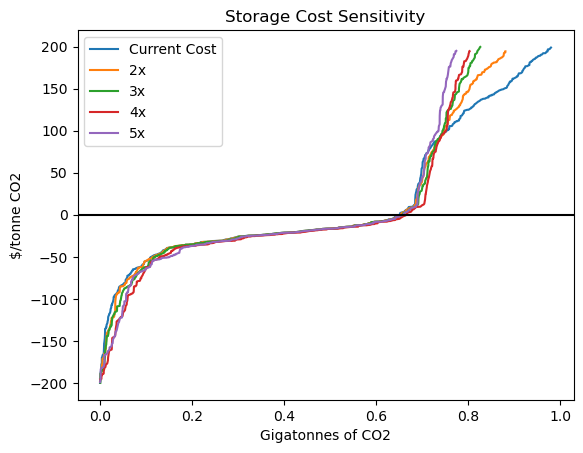

In [6]:
#Make empty arrays 
size = [len(plant_data["state"]),5]
metric = np.zeros(size)
cum_red = np.zeros(size)
counter =0 

for i in range(1,6):
    #Process State Plant Cost Data 
    state_plant_cost = rd.process_regional_plant_cost(os.getcwd(),i)
    plant_data["rep_fuel"], plant_data["metric"], plant_data["em_red"] = replacement.replacement_df(plant_data, cost_dict, regional_fuel_price, state_plant_cost, hold_dict, emissions_dict, 0,.06, 30,metric=1)
    US_MACC = replacement.set_macc(plant_data, neg_cap=-200, cap=200)
    US_MACC["ori_rep"] = US_MACC["ori_rep"].replace("CC_|SC_", "", regex=True)
    new_capacity = replacement.size_capacity(US_MACC["capacity"], (US_MACC["rep_fuel"].map(cf_dict))) * 8760 # converting back to MW
    US_MACC["new_capacity"] = new_capacity
    metric[0:len(US_MACC["metric"]),counter] = US_MACC["metric"]
    cum_red[0:len(US_MACC["metric"]),counter] = US_MACC["cum_red"]
    print(US_MACC["ori_rep"].value_counts())
    counter +=1
# Plot 
for i in range(counter):
    cum_red_col = cum_red[:, i]
    metric_col = metric[:, i]
    
    # Filter out the zero values
    non_zero_indices = np.nonzero(cum_red_col)
    cum_red_non_zero = cum_red_col[non_zero_indices]
    metric_non_zero = metric_col[non_zero_indices]
    
    # Plot the non-zero data
    plt.plot(cum_red_non_zero, metric_non_zero)


plt.axhline(y=0,color="black")
plt.ylabel("$/tonne CO2")
plt.xlabel("Gigatonnes of CO2")
plt.legend(["Current Cost","2x","3x","4x","5x"])
plt.title("Storage Cost Sensitivity")
plt.savefig("storage_cost.png", dpi = 600)


In [32]:
print(num)
print(US_MACC["ori_rep"].value_counts())



[731. 587. 518. 485. 453.]
Gas_CC→Gas      138
Coal→Gas        136
Gas_CC→Wind      77
Gas_SC→Gas       44
Coal→Wind        29
Gas_SC→Wind      20
Gas_CC→Solar      5
Gas_SC→Solar      3
Oil→Gas           1
Name: ori_rep, dtype: int64


### Analysis of Older Plant Transitions

In [6]:

# Merge Plant data with EIA data again to get plant retirement years


# Step 3: Convert 'Planned Retirement Year' column to integers
EIA_860_23 = pd.read_csv(os.path.join(os.getcwd(), "data", "raw","EIA","2023","3_1_Generator_Y2020.csv"), dtype='str', header = 1, comment= "#")
EIA_860_23.drop_duplicates(subset=["Plant Name"], keep='first', inplace=True, ignore_index=True)
EIA_860_23.drop_duplicates(subset=['Plant Name', 'Planned Retirement Year'], keep=False, inplace=True, ignore_index=True)
EIA_860_23 = EIA_860_23.dropna(subset=['Planned Retirement Year'])
retirement_year = (EIA_860_23[['Plant Name', 'Planned Retirement Year']])
plant_data_2 = pd.merge(retirement_year, plant_data, left_on='Plant Name', right_on='name', how='right',suffixes=(False,False))
plant_data_2.drop(columns=["Plant Name"])
plant_data_2.to_csv(os.path.join(os.getcwd(), "data", "processed","plan_data_2.0.csv"))

# Find Plants and create new dataframe 

# Constants
curr_year = 2023

# Create Empty dataframes with same columns as original plant data 
old_plant_data = plant_data_2.iloc[:0]
young_plant_data = old_plant_data 
age_arr = [] 
# Find plants and add to new dataframe 
for plant in plant_data["name"]:
    age = curr_year - plant_data.loc[plant_data['name'] == plant, 'commissioning_year'].iloc[0]
    if age >= 40:   
        age_arr.append(age)
        old_plant = plant_data.loc[plant_data["name"] == plant]
        old_plant_data = pd.concat([old_plant_data,old_plant])
    if age <= 10: 
        age_arr.append(age)
        young_plant = plant_data.loc[plant_data["name"] == plant]
        young_plant_data = pd.concat([young_plant_data,young_plant])

# Save 
old_plant_data.to_csv(os.path.join(os.getcwd(), "output", "Plant_Processed", "2022_plant_old.csv"))
young_plant_data.to_csv(os.path.join(os.getcwd(), "output", "Plant_Processed", "2022_plant_young.csv"))





# Recalculate cf for new MACC calculations
points = old_plant_data.loc[:, ["lat", "lon"]].values
pv_locs = pv_cf_data[["latitude", "longitude"]].values
wind_locs = wind_cf_data[["latitude", "longitude"]].values
pv_cfs = replacement.select_cf(points, pv_locs, pv_cf_data["capacity_factor"].values)
wind_cfs = replacement.select_cf(points, wind_locs, wind_cf_data["capacity_factor"].values)
hold_dict = cf_dict.copy()
hold_dict["Solar"] = pv_cfs
hold_dict["Wind"] = wind_cfs

# Calculate MACC
old_plant_data["rep_fuel"], old_plant_data["metric"], old_plant_data["em_red"] = replacement.replacement_df(old_plant_data, cost_dict,regional_fuel_price,state_plant_cost, hold_dict, emissions_dict, 0, 0.06, 30,metric=1)
US_MACC_2022_old = replacement.set_macc(old_plant_data, neg_cap = -200, cap = 200)
US_MACC_2022_old["ori_rep"] = US_MACC_2022_old["ori_rep"].replace("CC_|SC_", "", regex = True) 
new_capacity = replacement.size_capacity(US_MACC_2022_old["capacity"],(US_MACC_2022_old["rep_fuel"].map(cf_dict)))*8760 # converting back to MW
US_MACC_2022_old["new_capacity"] = new_capacity 
US_MACC_2022_old.to_csv(os.path.join(os.getcwd(), "output", "MACC_DATA", "2022_old.csv"))
nan_mask = US_MACC_2022_old.isna()


# Plot 
plotMACC.plot_MACC(US_MACC_2022_old, title = " 2022 MACC", x_lab = "Gigatonnes of CO2", save = True, file=os.path.join(os.getcwd(), "output", "NationalCurves", "2022_MACC_old.png"))

#Find transitions
transitions=  US_MACC_2022_old["ori_rep"].value_counts()
#print(transitions)

#print("Average Age":,sum(age_arr)/len(age_arr))


#Emissions Reduction from older plants 
print("Emissions Reduction from plants >40yrs ol:d",round(US_MACC_2022_old["cum_red"].iloc[-1],2),"Gt CO2")


/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/natalieciaccia/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/natalieciaccia/Desktop/Research_Winter_22/MACCpy-main/output/NationalCurves/2022_MACC_old.png


Emissions Reduction from plants >40yrs ol:d 0.55 Gt CO2


### Find Age Distribution of Plants

In [7]:
# Find plants and add to new dataframe 
df2 = pd.DataFrame(columns = ["name","state","age"])
for plant in plant_data["name"]:
    if plant_data.loc[plant_data['name'] == plant, 'primary_fuel'].iloc[0] == "Coal":
        age = curr_year - plant_data.loc[plant_data['name'] == plant, 'commissioning_year'].iloc[0]
        df2 = df2.append({'name': plant, "state": plant_data.loc[plant_data['name'] == plant, 'state'].iloc[0], 'age': age}, ignore_index=True)
        
df_state = pd.DataFrame()
df_state["state"] = list(df2["state"]) 
age_state = df2.groupby('state')['age'].mean()
df = pd.merge(df_state,age_state, on = "state")

# Plot 
plotMACC.age_dist_plot(df)



/var/folders/z6/zgz0vwq97gb45fcnpfp_j6s80000gn/T/ipykernel_58778/1023649270.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/var/folders/z6/zgz0vwq97gb45fcnpfp_j6s80000gn/T/ipykernel_58778/1023649270.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/var/folders/z6/zgz0vwq97gb45fcnpfp_j6s80000gn/T/ipykernel_58778/1023649270.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/var/folders/z6/zgz0vwq97gb45fcnpfp_j6s80000gn/T/ipykernel_58778/1023649270.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/var/folders/z6/zgz0vwq97gb45fcnpfp_j6s80000gn/T/ipykernel_58778/1023649270.py:6: FutureWarning: The frame.append method is deprecated and w

In [ ]:
#Find transitions
transitions=  US_MACC_2022_old["ori_rep"].value_counts()
print(transitions)
print("Emissions Reduction from plants >40yrs ol:d",round(US_MACC_2022_old["cum_red"].iloc[-1],2),"Gt CO2")


In [64]:
# Make dataframe only with plants that have planned retirement within 5 years 
filtered_df = plant_data_2[pd.to_numeric(plant_data_2['Planned Retirement Year'], errors='coerce').notna()]
filtered_df["Planned Retirement Year"] = [int(num) for num in filtered_df["Planned Retirement Year"]]
filtered_df = filtered_df[filtered_df['Planned Retirement Year']<= curr_year + 5] 
filtered_df = filtered_df[filtered_df['primary_fuel']== "Coal"]
print(len(filtered_df['Planned Retirement Year']))

# Run MACC 

# Recalculate cf for new MACC calculations
points = filtered_df.loc[:, ["lat", "lon"]].values
pv_locs = pv_cf_data[["latitude", "longitude"]].values
wind_locs = wind_cf_data[["latitude", "longitude"]].values
pv_cfs = replacement.select_cf(points, pv_locs, pv_cf_data["capacity_factor"].values)
wind_cfs = replacement.select_cf(points, wind_locs, wind_cf_data["capacity_factor"].values)
hold_dict = cf_dict.copy()
hold_dict["Solar"] = pv_cfs
hold_dict["Wind"] = wind_cfs

filtered_df["rep_fuel"], filtered_df["metric"], filtered_df["em_red"] = replacement.replacement_df(filtered_df, cost_dict, regional_fuel_price, state_plant_cost, hold_dict, emissions_dict, 0, 0.06, 30,metric=1)
US_MACC_2022_retire = replacement.set_macc(filtered_df, neg_cap = -200, cap = 200)
US_MACC_2022_retire["ori_rep"] = US_MACC_2022_retire["ori_rep"].replace("CC_|SC_", "", regex = True) 
new_capacity = replacement.size_capacity(US_MACC_2022["capacity"],(US_MACC_2022_retire["rep_fuel"].map(cf_dict)))*8760 # converting back to MW
US_MACC_2022_retire["new_capacity"] = new_capacity 
US_MACC_2022_retire.to_csv(os.path.join(os.getcwd(), "output", "MACC_DATA", "2022_MACC_retire.csv"))
print(len(US_MACC_2022_retire["state"]))

print(US_MACC_2022_retire["ori_rep"].value_counts())
print(US_MACC_2022_retire["cum_red"].iloc[-1])
print(US_MACC_2022_retire["metric"].mean())

57
50
Coal→Gas     42
Coal→Wind     8
Name: ori_rep, dtype: int64
0.12234265710192069
-35.5572762471591


/var/folders/z6/zgz0vwq97gb45fcnpfp_j6s80000gn/T/ipykernel_58778/63678801.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Emissions Reduction and Replacement Types


## Total Emissions Reduction

In [1]:
em_red_2022 = US_MACC_2022["cum_red"].iloc[-1]
em_red_2022_no_gas_to_gas = US_MACC_2022_no_gas_to_gas["cum_red"].iloc[-1]
#em_red_2022_tax = US_MACC_tax["cum_red"].iloc[-1]
em_red_2022_no_gas = US_MACC_2022_no_gas["cum_red"].iloc[-1]
print("Original Emissions Reduction:",round(em_red_2022,3),"GtCO2")
print("Emissions Reduction Tranisitioning to Renewables Only:",round(em_red_2022_no_gas,3),"GtCO2")
print("Emissions Reduction No Gas to Gas Transitions:",round(em_red_2022_no_gas_to_gas,3),"GtCO2")

#print("Emissions Reduction with ITC tax credits:",round(em_red_2022_tax,2),"GtCO2")

print(US_MACC_2022["metric"].max())
# Emissions total from power sector currenctly (March 2023)
# gas,coal, petroleum 
emissions = [852/1000, 661/1000, 20/1000]

total = sum(emissions)


print("Percent Emissions Reduction:",round(em_red_2022/total,2)*100,"%")
print("Percent Emissions Reduction Transitioining to Renewables Only:",round(em_red_2022_no_gas/total,2)*100,"%")
print("Percent Emissions Reduction:",round(em_red_2022_no_gas_to_gas/total,2)*100,"%")

#print("Percent Emissions Reduction with ITC :",round(em_red_2022_tax/total,2)*100,"%")

NameError: name 'US_MACC_2022' is not defined

## Emissions Reduction at Negative Cost

In [42]:
# Find transitions at negative cost 
neg_cost_transitions = US_MACC_2022.loc[US_MACC_2022["metric"]<0]
non_neg_transitions = US_MACC_2022.loc[US_MACC_2022["metric"]>0]
neg_cost_transitions_no_gas = US_MACC_2022_no_gas.loc[US_MACC_2022_no_gas["metric"]<0]


type_neg = neg_cost_transitions["ori_rep"].value_counts()
type_no_neg = non_neg_transitions["ori_rep"].value_counts()
all_type = US_MACC_2022["ori_rep"].value_counts()
print(all_type)
#Sum Emissions Reduction 
emissions_red_neg = sum(neg_cost_transitions["em_red"])/10**9
emissions_red_neg_no_gas = sum(neg_cost_transitions_no_gas["em_red"])/10**9

#emissions_red_neg_tax = sum(neg_cost_transitions_tax["em_red"])/10**9

print("Emissions Reduction at negative Cost",round(emissions_red_neg,2),"GtCO2")
print("Emissions Reduction at negative Cost Renewables Only",round(emissions_red_neg_no_gas,2),"GtCO2")

#print("Emissions Reduction at negative Cost with ITC",round(emissions_red_neg_tax,2),"GtCO2")
print("Percent Emissions Reduction at Negative Cost:",round(emissions_red_neg/total,2)*100,"%")

Coal→Gas        175
Gas_CC→Wind     169
Gas_CC→Gas      162
Gas_SC→Gas       97
Gas_SC→Wind      88
Coal→Wind        18
Gas_SC→Solar     13
Gas_CC→Solar      7
Oil→Gas           2
Oil→Wind          1
Name: ori_rep, dtype: int64
Emissions Reduction at negative Cost 0.66 GtCO2
Emissions Reduction at negative Cost Renewables Only 0.11 GtCO2
Percent Emissions Reduction at Negative Cost: 43.0 %


## Transition Types with Tax Credits

In [34]:
# Plant count 
type_tax = US_MACC_tax["ori_rep"].value_counts()
print(type_tax)

Gas_CC→Wind     217
Coal→Gas        176
Gas_CC→Gas      126
Gas_SC→Gas      100
Gas_SC→Wind      86
Gas_CC→Solar     22
Coal→Wind        21
Gas_SC→Solar     13
Oil→Gas           2
Oil→Wind          1
Name: ori_rep, dtype: int64


In [ ]:
em_red_org = US_MACC_org["cum_red"].iloc[-1]
em_red_2023_young = US_MACC_2023_young["cum_red"].iloc[-1] 
em_red_2033 = US_MACC_2033["cum_red"].iloc[-1]
em_red_old = US_MACC_2023_old["cum_red"].iloc[-1]


print("Original Emissions Reduction:",em_red_org)
print("Emissions Reduction Transitioning Young in 2023 and Old in 2033:",em_red_2033+em_red_2023_young)




Original Emissions Reduction: 0.9751946802193721
Emissions Reduction Transitioning Young in 2023 and Old in 2033: 0.9952515479419075


## Compare Transition Types Depending on Transition Year 


In [ ]:

transitions_original =  US_MACC_org["ori_rep"].value_counts()
transitions_old_2023 = US_MACC_2023_old["ori_rep"].value_counts()

transitions_old_2033 = US_MACC_2033["ori_rep"].value_counts()

print( )
print("2022 Old Plant Transitions:",transitions_old_2023)
print( )
print("2033 Old Transitions:",transitions_old_2033)
print("")


#transition_present["ori_rep"].value_counts()


2022 Old Plant Transitions: Gas_Gas     109
Coal_Gas     77
Gas_Wind     11
Oil_Gas       3
Name: ori_rep, dtype: int64

2033 Old Transitions: Gas_Gas     109
Coal_Gas     77
Gas_Wind     11
Oil_Gas       3
Name: ori_rep, dtype: int64



## Maps
#### All decisions

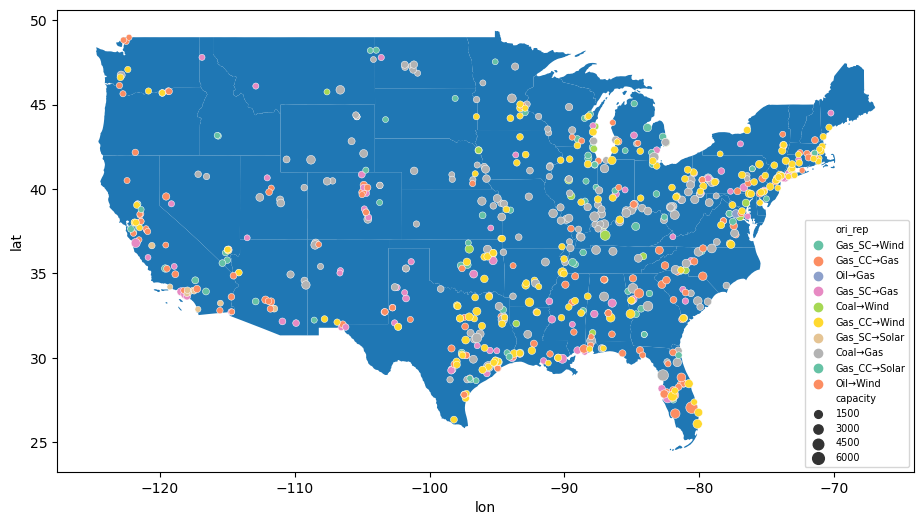

In [41]:
zipfile = "zip://"+os.path.join(os.getcwd(), "data", "raw", "mapping", "cb_2018_us_state_20m.zip")
states = gpd.read_file(zipfile)

fig, ax = plt.subplots(1, figsize=(20, 6))
states[states.NAME.isin(constants.US_CONTINENTAL)].plot(ax = ax)

sns.scatterplot(data=US_MACC_2022, x="lon", y="lat", hue="ori_rep", size = "capacity", palette = "Set2")
plt.legend(fontsize="7", loc ="lower right")
plt.savefig("output\\rep_map_22_regional.png", dpi = 600)


#### Gas combined cycle replacements

<AxesSubplot:xlabel='lon', ylabel='lat'>

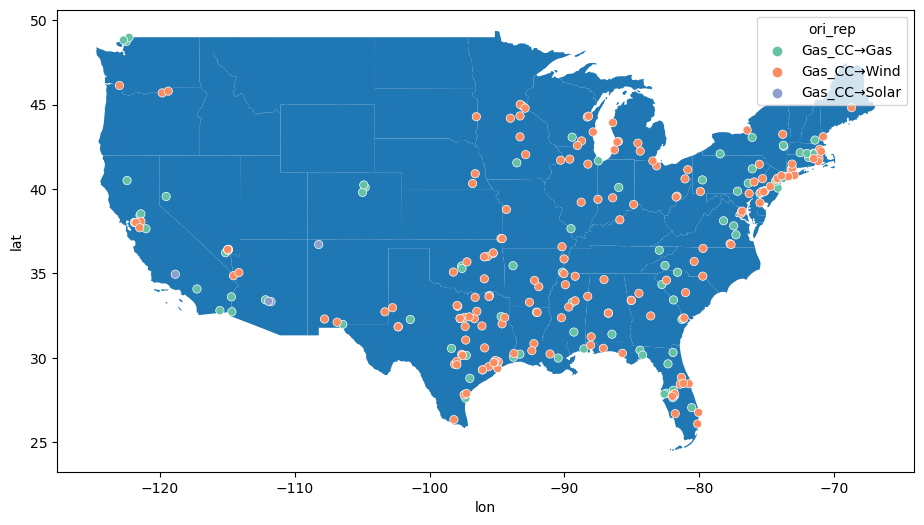

In [ ]:
fig, ax = plt.subplots(1, figsize=(20, 6))
states[states.NAME.isin(constants.US_CONTINENTAL)].plot(ax = ax)

US_MACC_gas = US_MACC_org[US_MACC_org["primary_fuel"].isin(["Gas_CC"])]
sns.scatterplot(data=US_MACC_gas, x="lon", y="lat", hue="ori_rep", palette = "Set2")
# plt.savefig("output\\rep_map.png", dpi = 600)

#### Gas single cycle replacements

NameError: name 'US_MACC' is not defined

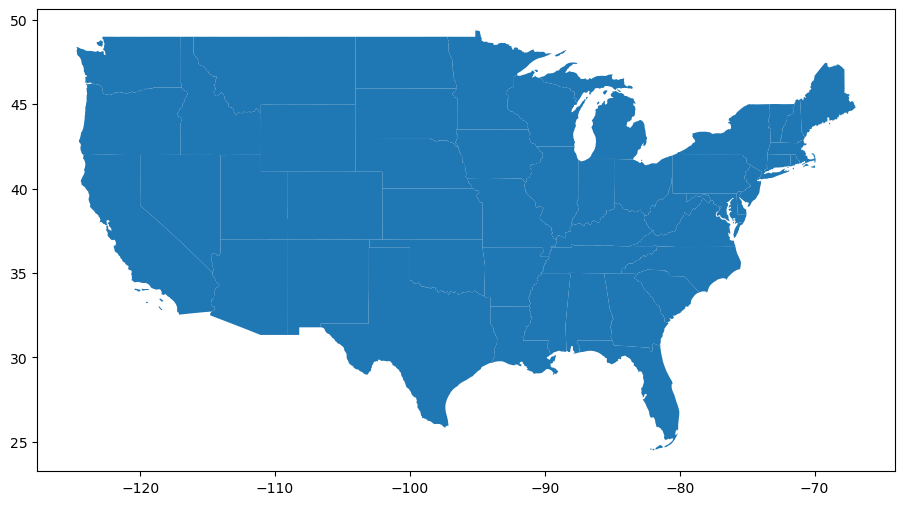

In [ ]:
fig, ax = plt.subplots(1, figsize=(20, 6))
states[states.NAME.isin(constants.US_CONTINENTAL)].plot(ax = ax)

US_MACC_gas = US_MACC[US_MACC["primary_fuel"].isin(["Gas_SC"])]
sns.scatterplot(data=US_MACC_gas, x="lon", y="lat", hue="ori_rep", palette = "Set2")
# plt.savefig("output\\rep_map.png", dpi = 600)

### State level curves

In [ ]:
states = US_MACC.state.unique()
for state in states:
    plotMACC.highlight_state(US_MACC, state, title = "", x_lab = "Gigatonnes of CO2", file = os.path.join(os.getcwd(), "output", "StateCurves", state+"_MACC_all.png"))

    state_subset = plant_data[plant_data.state == state]

    
    hold_dict["Solar"] = pv_cfs[plant_data.reset_index().state == state]
    hold_dict["Wind"] = wind_cfs[plant_data.reset_index().state == state]

    state_subset["rep_fuel"], state_subset["metric"], state_subset["em_red"] = replacement.replacement_df(state_subset, cost_dict, hold_dict, emissions_dict, 0, 0.06, 30, metric=1)
    STATE_MACC = replacement.set_macc(state_subset, neg_cap = -200, cap = 200)
    STATE_MACC["ori_rep"] = STATE_MACC["ori_rep"].replace("CC_|SC_", "", regex = True) 
    plotMACC.plot_MACC(STATE_MACC, title = "", x_lab = "Gigatonnes of CO2", save = True, file=os.path.join(os.getcwd(), "output", "StateCurves", state+"_MACC.png"))

c:\Users\natal\Desktop\Research Winter 22\MACCpy-main\./functions\plotMACC.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\natal\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\natal\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: c:\Users\natal\Desktop\Research Winter 22\MACCpy-main\output\StateCurves\NY_MACC_all.png


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\natal\\Desktop\\Research Winter 22\\MACCpy-main\\output\\StateCurves\\NY_MACC_all.png'

### Upfront costs

In [ ]:
plant_inital_capital = plant_data["capacity"].values*1000*plant_data["primary_fuel"].map(cost_dict["capital_cost_per_kw"]).values
loc_cfs = np.zeros(len(plant_data))
for i in range(len(plant_data)):
    fuel = plant_data.reset_index().loc[i, "rep_fuel"]
    if fuel == "Gas":
        loc_cfs[i] = 0.65
    else:
        loc_cfs[i] = pv_cfs[i] if fuel == "Solar" else wind_cfs[i]


rep_initial_capital = plant_data.reset_index()["rep_fuel"].map(cost_dict["capital_cost_per_kw"])*replacement.size_capacity(plant_data.reset_index()["generation"], pd.Series(loc_cfs))
remain_cap = cost.remaining_capital(plant_inital_capital, 2020-plant_data["commissioning_year"].values, 0.06, 30)

initial_payment = remain_cap + rep_initial_capital
plant_data["remaining_cap"] = remain_cap
plant_data["upfront_cost"] = initial_payment.values


In [ ]:
cols = ["metric", "capacity", "generation", "emissions", "em_red"]
threshholds = [0, 25, 50, 100] # $/tonne tax

US_MACC_costs = replacement.set_macc(plant_data, neg_cap = -200, cap = 200)
tot = plant_data[cols].sum(axis=0)

cum_results = pd.DataFrame()
for threshhold in threshholds:
    print("At a $"+str(threshhold)+" per tonne carbon price upfront costs of cost effective replacements would be "+str(round(US_MACC_costs[US_MACC_costs.metric<= threshhold]["upfront_cost"].sum(axis=0)/1E9, 3))+" Billion Dollars")
    print("At a $"+str(threshhold)+" per tonne carbon price average upfront costs (capacity weighted) of cost effective replacements would be "+str(round((US_MACC_costs[US_MACC_costs.metric<= threshhold]["upfront_cost"]*US_MACC_costs[US_MACC_costs.metric<= threshhold]["capacity"]).sum(axis=0)/(1E9*US_MACC_costs[US_MACC_costs.metric<= threshhold]["capacity"].sum(axis=0)), 3))+" Billion Dollars")
cum_results



At a $0 per tonne carbon price upfront costs of cost effective replacements would be 274.695 Billion Dollars
At a $0 per tonne carbon price average upfront costs (capacity weighted) of cost effective replacements would be 1.605 Billion Dollars
At a $25 per tonne carbon price upfront costs of cost effective replacements would be 393.6 Billion Dollars
At a $25 per tonne carbon price average upfront costs (capacity weighted) of cost effective replacements would be 1.948 Billion Dollars
At a $50 per tonne carbon price upfront costs of cost effective replacements would be 477.465 Billion Dollars
At a $50 per tonne carbon price average upfront costs (capacity weighted) of cost effective replacements would be 2.232 Billion Dollars
At a $100 per tonne carbon price upfront costs of cost effective replacements would be 634.806 Billion Dollars
At a $100 per tonne carbon price average upfront costs (capacity weighted) of cost effective replacements would be 2.182 Billion Dollars


/Users/natalieciaccia/Desktop/Research_Winter_22/MACCpy-main/./functions/replacement.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/natalieciaccia/Desktop/Research_Winter_22/MACCpy-main/./functions/replacement.py:332: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/natalieciaccia/Desktop/Research_Winter_22/MACCpy-main/./functions/replacement.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

Empty DataFrame
Columns: []
Index: []

In [95]:
plotMACC.cf_plot(pv_cf_data,US_MACC_2022.loc[US_MACC_2022["rep_fuel"]=="Solar"])


In [94]:
plotMACC.cf_plot(wind_cf_data,US_MACC_2022.loc[US_MACC_2022["rep_fuel"]=="Wind"])

## Percent impact from taxes
Percentage of capacity, generation, emissions, and emissions reductions. The emissions row tells you what fraction of emissions have been affected while em_red tells you the actual percentage of emissions reduced. Eg if at $25/tonne 10% of emissions have been affected (but some of those replacements were to gas) then only 5% of emissions were reduced.

In [ ]:
tot = plant_data[cols].sum(axis=0)

cum_results = pd.DataFrame()
for threshhold in threshholds:
    cum_results[str(threshhold)] = plant_data[plant_data.metric<= threshhold][cols].sum(axis=0).div(tot)
    cum_results.at["em_red", str(threshhold)] = cum_results.loc["em_red", str(threshhold)]*tot["em_red"]/tot["emissions"]
cum_results

0        25        50       100
metric      1.546297  1.540907  1.530485  1.503586
capacity    0.277279  0.425953  0.570321  0.698178
generation  0.093001  0.260188  0.488432  0.666761
emissions   0.105693  0.352391  0.665263  0.792377
em_red      0.058557  0.244787  0.465679  0.575921

### State level remaining capital 

In [ ]:
state_remaining_capital = plant_data.groupby(["state", "primary_fuel"])[["state", "primary_fuel", "remaining_cap"]].sum().reset_index().sort_values("state")

import plotly.express as px

fig = px.bar(state_remaining_capital, x='state', y='remaining_cap', color = "primary_fuel", category_orders={"state":list(np.unique(state_remaining_capital.state))})

fig.update_xaxes(
    tickvals=np.unique(state_remaining_capital.state),
    title_text = "State"
)
fig.update_yaxes(
    title_text = "Remaining Capital (US $2021)"
)
fig.show()

# fig.write_image("output/remaining_capital.png")